In [ ]:
# import necessary dependencies
import argparse
import os, sys
import time
from datetime import datetime
import time
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")

## Prepare

In [ ]:
# arguments
DATA_ROOT = "./data"
TEACHER_CHECKPOINT = "Teacher_trained_parameters.pt"
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 64

# parameters
RANDOM_SEED = 42
IMG_SIZE = 28
N_CLASSES = 10
DROPOUT = 0.5
TEMP = 20

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {DEVICE}")

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

Device: cuda


In [ ]:
# construct dataset
data_transforms = {'train': transforms.Compose([transforms.RandomCrop(size=IMG_SIZE, padding=2),
                                      transforms.ToTensor()]),
                   'test': transforms.Compose([transforms.ToTensor()])}

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=True, download=True, transform=data_transforms['train']),
  batch_size=TRAIN_BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=False, download=True, transform=data_transforms['test']),
  batch_size=VAL_BATCH_SIZE, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Check Images

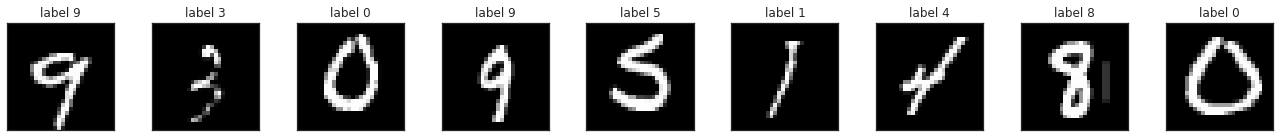

In [ ]:
batch_idx, (example_data, example_targets) = next(enumerate(test_loader))

fig = plt.figure(figsize=(18, 4))
for i in range(9):
    ax = plt.subplot(1,9,i+1)
    ax.set_title(f"label {example_targets[i]}")
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])

## Training

In [ ]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''  
    model.eval()
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    acc = correct_pred.float() / n
    
    return acc.item()

def plot_losses(train_losses, valid_losses, title_prefix):
    '''
    Function for plotting training and validation losses
    '''
    plt.figure(figsize=(6, 4),dpi=80)
    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)
    
    plt.plot(train_losses, color='blue', label='Training loss') 
    plt.plot(valid_losses, color='red', label='Validation loss')
    plt.title(f"{title_prefix}: Loss over epochs") 
    plt.xlabel('Epoch')
    plt.ylabel('Loss') 
    plt.legend()
    
    plt.show()

def train(train_loader, model, criterion, optimizer, device, teacher_model=None):
    '''
    Function for the training step of the training loop
    '''
    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        if not teacher_model:
            loss = criterion(y_hat, y_true)
        else:
            with torch.no_grad():
                y_teacher = teacher_model(X)
            loss = criterion(y_hat, y_true, y_teacher)
            
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
    model.eval()
    running_loss = 0
    
    with torch.no_grad():
        for X, y_true in valid_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            # Forward pass and record loss
            y_hat, _ = model(X) 
            loss = criterion(y_hat, y_true) 
            running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss


def training_loop(model, train_criterion, valid_criterion, optimizer, train_loader, valid_loader, 
                  epochs, device, params, print_every=1, teacher_model=None):
    '''
    Function defining the entire training loop
    '''
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    acc_epochs = []
    train_accus = []
    valid_accus = []
    

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, train_criterion, optimizer, device, teacher_model)
        train_losses.append(train_loss)

        # validation
        model, valid_loss = validate(valid_loader, model, valid_criterion, device)
        valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            acc_epochs.append(epoch)
            train_acc = get_accuracy(model, train_loader, device=device)
            train_accus.append(train_acc)
            valid_acc = get_accuracy(model, valid_loader, device=device)
            valid_accus.append(valid_acc)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    # save metrics
    plot_losses(train_losses, valid_losses, params['title'])
    res_acc = pd.DataFrame({
        "acc_epoch": acc_epochs,
        "train_accus": train_accus,
        "valid_accus": valid_accus
    })
    res_loss = pd.DataFrame({
        "loss_epoch": range(0, epochs),
        "train_losses": train_losses,
        "valid_losses": valid_losses,
    })
    str_time = datetime.now().strftime("%m-%d_%H-%M")
    res_acc.to_csv(f"{params['dir']}/{params['prefix']}_{str_time}_accus.csv", index=False)
    res_loss.to_csv(f"{params['dir']}/{params['prefix']}_{str_time}_losses.csv", index=False)
    
    return model, optimizer, (train_losses, valid_losses)

### Models

In [ ]:
class LargeNet(nn.Module):

    def __init__(self, n_classes, dropout_ratio=0.5, temperature=1):
        super(LargeNet, self).__init__()
        
        self.model = nn.Sequential(            
            nn.Linear(28*28, 1200),
            nn.ReLU(),
            nn.Dropout(p=dropout_ratio),
            nn.Linear(1200, 1200),
            nn.ReLU(),
            nn.Dropout(p=dropout_ratio),
            nn.Linear(1200, 10)
        )
        self.T = temperature
 
    def forward(self, x):
        x = x.view(-1, 28*28)
        logits = self.model(x)
        probs = F.softmax(logits/self.T, dim=1)
        return logits, probs


class SmallNet(nn.Module):

    def __init__(self, n_classes, temperature=1):
        super(SmallNet, self).__init__()
        
        self.model = nn.Sequential(            
            nn.Linear(28*28, 800),
            nn.ReLU(),
            nn.Linear(800, 800),
            nn.ReLU(),
            nn.Linear(800, 10)
        )
        self.T = temperature
 
    def forward(self, x):
        x = x.view(-1, 28*28)
        logits = self.model(x)
        probs = F.softmax(logits/self.T, dim=1)
        return logits, probs

### Train Teacher Model

==========> Teacher model
14:23:20 --- Epoch: 1	Train loss: 0.3106	Valid loss: 0.1234	Train accuracy: 94.24	Valid accuracy: 96.31
14:24:04 --- Epoch: 3	Train loss: 0.1918	Valid loss: 0.0847	Train accuracy: 96.30	Valid accuracy: 97.39
14:24:49 --- Epoch: 5	Train loss: 0.1543	Valid loss: 0.0645	Train accuracy: 96.96	Valid accuracy: 98.07
14:25:33 --- Epoch: 7	Train loss: 0.1351	Valid loss: 0.0541	Train accuracy: 97.53	Valid accuracy: 98.28
14:26:17 --- Epoch: 9	Train loss: 0.1223	Valid loss: 0.0522	Train accuracy: 97.77	Valid accuracy: 98.38
14:27:02 --- Epoch: 11	Train loss: 0.1111	Valid loss: 0.0511	Train accuracy: 97.87	Valid accuracy: 98.38
14:27:46 --- Epoch: 13	Train loss: 0.1049	Valid loss: 0.0461	Train accuracy: 98.14	Valid accuracy: 98.57


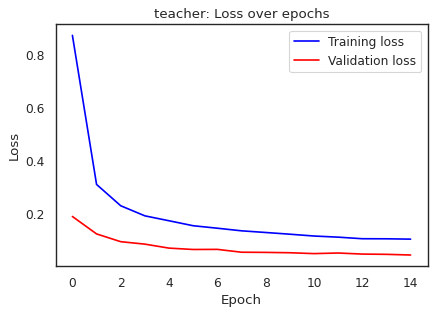


teacher model valid accuracy: 0.9855


In [ ]:
print("==========> Teacher model")

model_teacher = LargeNet(N_CLASSES, DROPOUT, TEMP).to(DEVICE)

LEARNING_RATE = 0.01
N_EPOCHS = 15
optimizer = torch.optim.SGD(model_teacher.parameters(), lr=LEARNING_RATE, momentum=0.9)
train_criterion = nn.CrossEntropyLoss()
valid_criterion = nn.CrossEntropyLoss()
params = {"dir":'.',
            "prefix": "teacher",
            "title": "teacher"
            }

model_teacher, optimizer, _ = training_loop(model_teacher, train_criterion, valid_criterion, optimizer, 
                                            train_loader, test_loader, N_EPOCHS, DEVICE, params, print_every=2)

# Save model 
torch.save(model_teacher.state_dict(), TEACHER_CHECKPOINT)

valid_acc = get_accuracy(model_teacher, test_loader, DEVICE)
print(f"\nteacher model valid accuracy: {valid_acc:.4f}")

### Train Student Model
#### Q2
Train student model base on groud Truth

=======> Student trained on Ground Truth
14:28:46 --- Epoch: 1	Train loss: 0.1906	Valid loss: 0.1103	Train accuracy: 94.98	Valid accuracy: 96.41
14:29:30 --- Epoch: 3	Train loss: 0.1164	Valid loss: 0.0824	Train accuracy: 96.64	Valid accuracy: 97.54
14:30:15 --- Epoch: 5	Train loss: 0.0884	Valid loss: 0.0586	Train accuracy: 97.65	Valid accuracy: 98.12
14:30:59 --- Epoch: 7	Train loss: 0.0745	Valid loss: 0.0509	Train accuracy: 97.94	Valid accuracy: 98.39
14:31:43 --- Epoch: 9	Train loss: 0.0647	Valid loss: 0.0404	Train accuracy: 98.11	Valid accuracy: 98.61
14:32:28 --- Epoch: 11	Train loss: 0.0570	Valid loss: 0.0385	Train accuracy: 98.32	Valid accuracy: 98.69
14:33:12 --- Epoch: 13	Train loss: 0.0500	Valid loss: 0.0368	Train accuracy: 98.57	Valid accuracy: 98.85


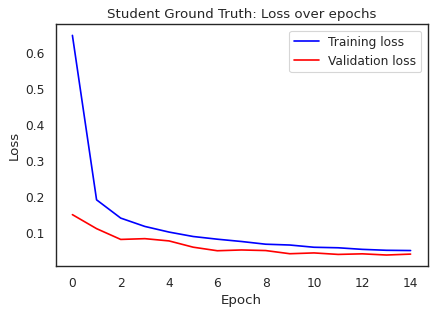


student model valid accuracy: 0.9874


In [ ]:
print(f"=======> Student trained on Ground Truth")

LEARNING_RATE = 0.015
N_EPOCHS = 15

model_s_true = SmallNet(N_CLASSES).to(DEVICE)
optimizer = torch.optim.SGD(model_s_true.parameters(), lr=LEARNING_RATE, momentum=0.9)

train_criterion = nn.CrossEntropyLoss()
valid_criterion = nn.CrossEntropyLoss()


dir_path = "./student_models/student_ground_truth"
params = {"dir": dir_path,
          "prefix": "student", 
          "title": "Student Ground Truth"
         }

if not os.path.exists(dir_path):
    os.makedirs(dir_path, exist_ok=True)

model_s_true, optimizer, _ = training_loop(model_s_true, train_criterion, valid_criterion, optimizer, train_loader, test_loader,
                                    N_EPOCHS, DEVICE, params, print_every=2)
torch.save(model_s_true.state_dict(), f"{dir_path}/student_ground_truth_parameters.pt")

valid_acc = get_accuracy(model_s_true, test_loader, DEVICE)
print(f"\nstudent model valid accuracy: {valid_acc:.4f}")

Train student model base on teacher's soft label

=======> Student trained on Soft Label
14:34:15 --- Epoch: 1	Train loss: 0.1450	Valid loss: 0.0542	Train accuracy: 97.44	Valid accuracy: 98.24
14:35:02 --- Epoch: 3	Train loss: 0.0829	Valid loss: 0.0508	Train accuracy: 97.70	Valid accuracy: 98.34
14:35:48 --- Epoch: 5	Train loss: 0.0667	Valid loss: 0.0483	Train accuracy: 97.87	Valid accuracy: 98.43
14:36:34 --- Epoch: 7	Train loss: 0.0584	Valid loss: 0.0482	Train accuracy: 97.94	Valid accuracy: 98.51
14:37:20 --- Epoch: 9	Train loss: 0.0531	Valid loss: 0.0470	Train accuracy: 98.04	Valid accuracy: 98.42
14:38:07 --- Epoch: 11	Train loss: 0.0487	Valid loss: 0.0460	Train accuracy: 98.01	Valid accuracy: 98.54
14:38:53 --- Epoch: 13	Train loss: 0.0467	Valid loss: 0.0454	Train accuracy: 98.07	Valid accuracy: 98.53


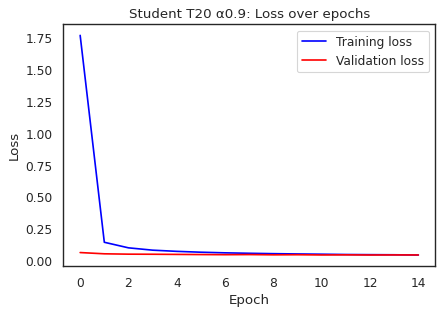


student model valid accuracy: 0.9853


In [ ]:
class SoftCrossEntropyLoss(nn.Module):
    def __init__(self, temperature, alpha):
        super(SoftCrossEntropyLoss, self).__init__()
        self.T = temperature
        self.alpha = alpha
    
    def forward(self, student_pred, label, teacher_pred):
        return nn.KLDivLoss(reduction="batchmean")(F.log_softmax(student_pred/self.T,dim=1), F.softmax(teacher_pred[0]/self.T, dim=1)) * self.alpha * self.T * self.T + \
    F.cross_entropy(student_pred, label) * (1-self.alpha)


# Train
LEARNING_RATE = 0.015
N_EPOCHS = 15
ALPHA = 0.9

print(f"=======> Student trained on Soft Label")
model_s_soft = SmallNet(N_CLASSES, TEMP).to(DEVICE)
optimizer = torch.optim.SGD(model_s_soft.parameters(), lr=LEARNING_RATE, momentum=0.9)

valid_criterion = nn.CrossEntropyLoss()
train_criterion = SoftCrossEntropyLoss(TEMP, ALPHA)
prefix = f"student_T{TEMP}_α{ALPHA}"
dir_path = f"./student_models/{prefix}"
if not os.path.exists(dir_path):
    os.makedirs(dir_path, exist_ok=True)

params = {"dir": dir_path,
      "prefix": prefix, 
      "title": f"Student T{TEMP} α{ALPHA}"
     }

model_s_soft, optimizer, _ = training_loop(model_s_soft, train_criterion, valid_criterion, optimizer, train_loader, test_loader,
                                    N_EPOCHS, DEVICE, params, print_every=2, teacher_model=model_teacher)
torch.save(model_s_soft.state_dict(), f"{dir_path}/{prefix}_parameters.pt")  

valid_acc = get_accuracy(model_s_soft, test_loader, DEVICE)
print(f"\nstudent model valid accuracy: {valid_acc:.4f}")

#### Q3
Different Temprature

=======> Temperature: 2
=======> Teacher model trained with Temperature 2
17:03:20 --- Epoch: 1	Train loss: 0.3028	Valid loss: 0.1170	Train accuracy: 94.47	Valid accuracy: 96.48
17:04:06 --- Epoch: 3	Train loss: 0.1926	Valid loss: 0.0788	Train accuracy: 96.28	Valid accuracy: 97.56
17:04:51 --- Epoch: 5	Train loss: 0.1558	Valid loss: 0.0728	Train accuracy: 96.79	Valid accuracy: 97.62
17:05:35 --- Epoch: 7	Train loss: 0.1350	Valid loss: 0.0554	Train accuracy: 97.43	Valid accuracy: 97.96
17:06:19 --- Epoch: 9	Train loss: 0.1181	Valid loss: 0.0524	Train accuracy: 97.75	Valid accuracy: 98.31
17:07:03 --- Epoch: 11	Train loss: 0.1102	Valid loss: 0.0480	Train accuracy: 97.91	Valid accuracy: 98.50
17:07:47 --- Epoch: 13	Train loss: 0.1022	Valid loss: 0.0452	Train accuracy: 98.01	Valid accuracy: 98.61


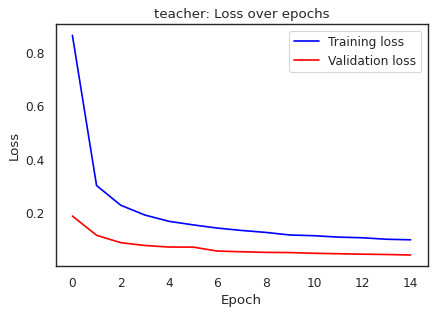

=======> Student model trained with Temperature 2
17:08:48 --- Epoch: 1	Train loss: 0.1123	Valid loss: 0.0641	Train accuracy: 96.89	Valid accuracy: 97.80
17:09:33 --- Epoch: 3	Train loss: 0.0442	Valid loss: 0.0497	Train accuracy: 97.65	Valid accuracy: 98.39
17:10:19 --- Epoch: 5	Train loss: 0.0320	Valid loss: 0.0461	Train accuracy: 97.94	Valid accuracy: 98.50
17:11:04 --- Epoch: 7	Train loss: 0.0267	Valid loss: 0.0461	Train accuracy: 98.02	Valid accuracy: 98.44
17:11:51 --- Epoch: 9	Train loss: 0.0236	Valid loss: 0.0446	Train accuracy: 98.00	Valid accuracy: 98.53
17:12:37 --- Epoch: 11	Train loss: 0.0214	Valid loss: 0.0440	Train accuracy: 98.09	Valid accuracy: 98.61
17:13:22 --- Epoch: 13	Train loss: 0.0203	Valid loss: 0.0426	Train accuracy: 98.09	Valid accuracy: 98.67


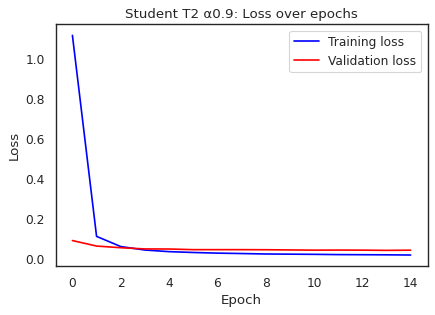


student model valid accuracy: 0.9866
=======> Temperature: 3
=======> Teacher model trained with Temperature 3
17:14:24 --- Epoch: 1	Train loss: 0.3064	Valid loss: 0.1135	Train accuracy: 94.47	Valid accuracy: 96.72
17:15:08 --- Epoch: 3	Train loss: 0.1932	Valid loss: 0.0877	Train accuracy: 96.06	Valid accuracy: 97.14
17:15:53 --- Epoch: 5	Train loss: 0.1555	Valid loss: 0.0657	Train accuracy: 97.05	Valid accuracy: 97.87
17:16:37 --- Epoch: 7	Train loss: 0.1348	Valid loss: 0.0567	Train accuracy: 97.48	Valid accuracy: 98.16
17:17:22 --- Epoch: 9	Train loss: 0.1203	Valid loss: 0.0496	Train accuracy: 97.80	Valid accuracy: 98.44
17:18:08 --- Epoch: 11	Train loss: 0.1092	Valid loss: 0.0467	Train accuracy: 97.96	Valid accuracy: 98.46
17:18:55 --- Epoch: 13	Train loss: 0.1050	Valid loss: 0.0450	Train accuracy: 98.12	Valid accuracy: 98.49


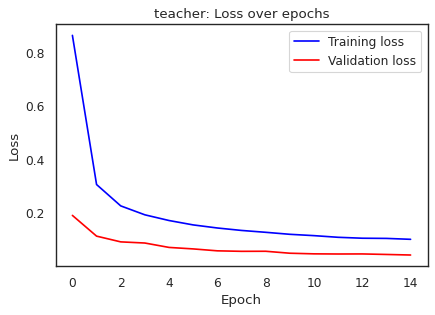

=======> Student model trained with Temperature 3
17:19:59 --- Epoch: 1	Train loss: 0.1152	Valid loss: 0.0538	Train accuracy: 97.28	Valid accuracy: 98.23
17:20:47 --- Epoch: 3	Train loss: 0.0551	Valid loss: 0.0490	Train accuracy: 97.73	Valid accuracy: 98.38
17:21:35 --- Epoch: 5	Train loss: 0.0426	Valid loss: 0.0448	Train accuracy: 97.87	Valid accuracy: 98.64
17:22:23 --- Epoch: 7	Train loss: 0.0366	Valid loss: 0.0430	Train accuracy: 97.94	Valid accuracy: 98.64
17:23:12 --- Epoch: 9	Train loss: 0.0327	Valid loss: 0.0432	Train accuracy: 98.02	Valid accuracy: 98.73
17:24:00 --- Epoch: 11	Train loss: 0.0301	Valid loss: 0.0427	Train accuracy: 98.04	Valid accuracy: 98.70
17:24:49 --- Epoch: 13	Train loss: 0.0283	Valid loss: 0.0423	Train accuracy: 98.05	Valid accuracy: 98.80


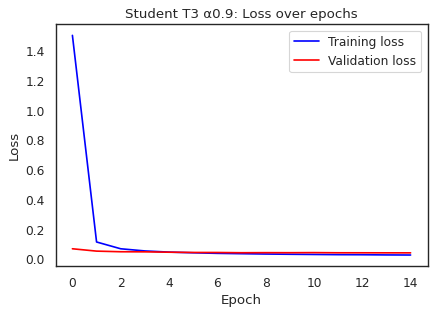


student model valid accuracy: 0.9871
=======> Temperature: 4
=======> Teacher model trained with Temperature 4
17:25:53 --- Epoch: 1	Train loss: 0.3069	Valid loss: 0.1177	Train accuracy: 94.05	Valid accuracy: 96.20
17:26:38 --- Epoch: 3	Train loss: 0.1919	Valid loss: 0.0763	Train accuracy: 96.42	Valid accuracy: 97.60
17:27:23 --- Epoch: 5	Train loss: 0.1566	Valid loss: 0.0676	Train accuracy: 97.01	Valid accuracy: 97.95
17:28:10 --- Epoch: 7	Train loss: 0.1371	Valid loss: 0.0544	Train accuracy: 97.50	Valid accuracy: 98.42
17:28:54 --- Epoch: 9	Train loss: 0.1222	Valid loss: 0.0514	Train accuracy: 97.77	Valid accuracy: 98.34
17:29:39 --- Epoch: 11	Train loss: 0.1117	Valid loss: 0.0497	Train accuracy: 97.83	Valid accuracy: 98.30
17:30:24 --- Epoch: 13	Train loss: 0.1037	Valid loss: 0.0449	Train accuracy: 98.07	Valid accuracy: 98.54


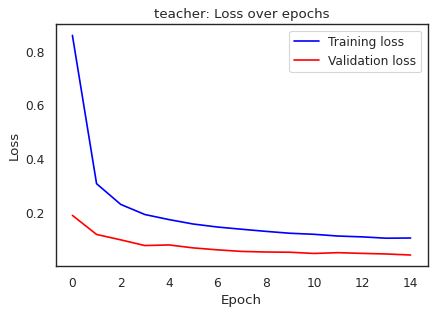

=======> Student model trained with Temperature 4
17:31:25 --- Epoch: 1	Train loss: 0.1205	Valid loss: 0.0527	Train accuracy: 97.37	Valid accuracy: 98.19
17:32:11 --- Epoch: 3	Train loss: 0.0642	Valid loss: 0.0465	Train accuracy: 97.69	Valid accuracy: 98.38
17:32:55 --- Epoch: 5	Train loss: 0.0504	Valid loss: 0.0455	Train accuracy: 97.82	Valid accuracy: 98.46
17:33:40 --- Epoch: 7	Train loss: 0.0440	Valid loss: 0.0438	Train accuracy: 97.85	Valid accuracy: 98.63
17:34:24 --- Epoch: 9	Train loss: 0.0400	Valid loss: 0.0431	Train accuracy: 97.97	Valid accuracy: 98.66
17:35:09 --- Epoch: 11	Train loss: 0.0373	Valid loss: 0.0423	Train accuracy: 98.00	Valid accuracy: 98.72
17:35:53 --- Epoch: 13	Train loss: 0.0349	Valid loss: 0.0422	Train accuracy: 97.99	Valid accuracy: 98.66


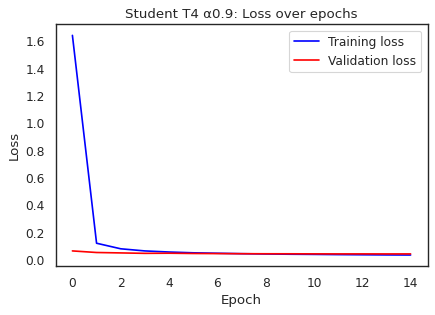


student model valid accuracy: 0.9866
=======> Temperature: 8
=======> Teacher model trained with Temperature 8
17:36:53 --- Epoch: 1	Train loss: 0.3090	Valid loss: 0.1125	Train accuracy: 94.76	Valid accuracy: 96.70
17:37:36 --- Epoch: 3	Train loss: 0.1950	Valid loss: 0.0811	Train accuracy: 96.35	Valid accuracy: 97.58
17:38:20 --- Epoch: 5	Train loss: 0.1548	Valid loss: 0.0639	Train accuracy: 97.00	Valid accuracy: 98.01
17:39:03 --- Epoch: 7	Train loss: 0.1343	Valid loss: 0.0598	Train accuracy: 97.46	Valid accuracy: 98.13
17:39:45 --- Epoch: 9	Train loss: 0.1246	Valid loss: 0.0487	Train accuracy: 97.82	Valid accuracy: 98.47
17:40:28 --- Epoch: 11	Train loss: 0.1112	Valid loss: 0.0458	Train accuracy: 97.99	Valid accuracy: 98.54
17:41:11 --- Epoch: 13	Train loss: 0.1043	Valid loss: 0.0437	Train accuracy: 98.17	Valid accuracy: 98.57


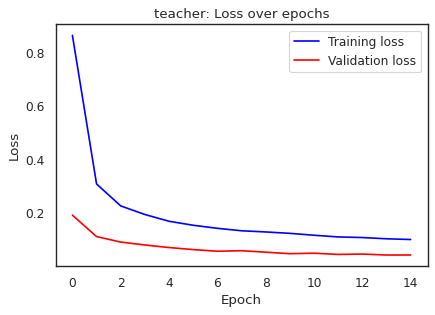

=======> Student model trained with Temperature 8
17:42:10 --- Epoch: 1	Train loss: 0.1504	Valid loss: 0.0539	Train accuracy: 97.28	Valid accuracy: 98.34
17:42:55 --- Epoch: 3	Train loss: 0.0847	Valid loss: 0.0502	Train accuracy: 97.63	Valid accuracy: 98.49
17:43:39 --- Epoch: 5	Train loss: 0.0676	Valid loss: 0.0478	Train accuracy: 97.82	Valid accuracy: 98.53
17:44:24 --- Epoch: 7	Train loss: 0.0588	Valid loss: 0.0463	Train accuracy: 97.81	Valid accuracy: 98.60
17:45:08 --- Epoch: 9	Train loss: 0.0532	Valid loss: 0.0461	Train accuracy: 97.86	Valid accuracy: 98.64
17:45:52 --- Epoch: 11	Train loss: 0.0498	Valid loss: 0.0452	Train accuracy: 97.83	Valid accuracy: 98.61
17:46:37 --- Epoch: 13	Train loss: 0.0463	Valid loss: 0.0454	Train accuracy: 97.94	Valid accuracy: 98.64


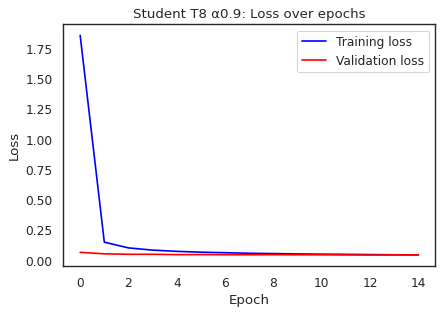


student model valid accuracy: 0.9863
=======> Temperature: 10
=======> Teacher model trained with Temperature 10
17:47:37 --- Epoch: 1	Train loss: 0.3053	Valid loss: 0.1125	Train accuracy: 94.70	Valid accuracy: 96.58
17:48:20 --- Epoch: 3	Train loss: 0.1964	Valid loss: 0.0824	Train accuracy: 96.26	Valid accuracy: 97.45
17:49:03 --- Epoch: 5	Train loss: 0.1539	Valid loss: 0.0662	Train accuracy: 96.95	Valid accuracy: 97.86
17:49:47 --- Epoch: 7	Train loss: 0.1357	Valid loss: 0.0570	Train accuracy: 97.48	Valid accuracy: 98.17
17:50:30 --- Epoch: 9	Train loss: 0.1185	Valid loss: 0.0495	Train accuracy: 97.73	Valid accuracy: 98.31
17:51:13 --- Epoch: 11	Train loss: 0.1144	Valid loss: 0.0489	Train accuracy: 97.91	Valid accuracy: 98.40
17:51:56 --- Epoch: 13	Train loss: 0.1046	Valid loss: 0.0471	Train accuracy: 98.17	Valid accuracy: 98.51


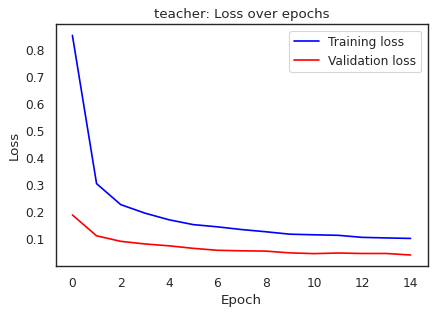

=======> Student model trained with Temperature 10
17:52:55 --- Epoch: 1	Train loss: 0.1475	Valid loss: 0.0529	Train accuracy: 97.33	Valid accuracy: 98.20
17:53:39 --- Epoch: 3	Train loss: 0.0844	Valid loss: 0.0466	Train accuracy: 97.69	Valid accuracy: 98.41
17:54:23 --- Epoch: 5	Train loss: 0.0669	Valid loss: 0.0458	Train accuracy: 97.71	Valid accuracy: 98.56
17:55:07 --- Epoch: 7	Train loss: 0.0591	Valid loss: 0.0435	Train accuracy: 97.95	Valid accuracy: 98.60
17:55:50 --- Epoch: 9	Train loss: 0.0537	Valid loss: 0.0437	Train accuracy: 97.87	Valid accuracy: 98.62
17:56:33 --- Epoch: 11	Train loss: 0.0500	Valid loss: 0.0431	Train accuracy: 97.98	Valid accuracy: 98.63
17:57:16 --- Epoch: 13	Train loss: 0.0473	Valid loss: 0.0426	Train accuracy: 98.05	Valid accuracy: 98.67


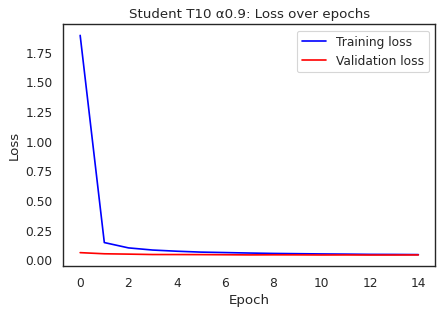


student model valid accuracy: 0.9857


In [11]:
# Train
LEARNING_RATE_T = 0.01
LEARNING_RATE_S = 0.015
N_EPOCHS = 15
ALPHA = 0.9

for T in [2, 3, 4, 8, 10]:
    print(f"=======> Temperature: {T}")
    print(f"=======> Teacher model trained with Temperature {T}")
    model_teacher = LargeNet(N_CLASSES, DROPOUT, T).to(DEVICE)
    optimizer = torch.optim.SGD(model_teacher.parameters(), lr=LEARNING_RATE_T, momentum=0.9)
    train_criterion = nn.CrossEntropyLoss()
    valid_criterion = nn.CrossEntropyLoss()
    params = {"dir":'.',
              "prefix": "teacher",
              "title": "teacher"
             }
    model_teacher, optimizer, _ = training_loop(model_teacher, train_criterion, valid_criterion, optimizer, 
                                                train_loader, test_loader, N_EPOCHS, DEVICE, params, print_every=2)

    print(f"=======> Student model trained with Temperature {T}")
    model_s_soft = SmallNet(N_CLASSES, T).to(DEVICE)
    optimizer = torch.optim.SGD(model_s_soft.parameters(), lr=LEARNING_RATE_S, momentum=0.9)
    
    train_criterion = SoftCrossEntropyLoss(T, ALPHA)
    valid_criterion = nn.CrossEntropyLoss()
    
    prefix = f"student_T{T}_α{ALPHA}"
    dir_path = f"./student_models/{prefix}"
    if not os.path.exists(dir_path):
        os.makedirs(dir_path, exist_ok=True)

    params = {"dir": dir_path,
          "prefix": prefix, 
          "title": f"Student T{T} α{ALPHA}"
         }

    model_s_soft, optimizer, _ = training_loop(model_s_soft, train_criterion, valid_criterion, optimizer, train_loader, test_loader,
                                        N_EPOCHS, DEVICE, params, print_every=2, teacher_model=model_teacher)
    torch.save(model_s_soft.state_dict(), f"{dir_path}/{prefix}_parameters.pt")
    
    valid_acc = get_accuracy(model_s_soft, test_loader, DEVICE)
    print(f"\nstudent model valid accuracy: {valid_acc:.4f}")
